/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.9550
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Weighted Precision: 0.9613
Weighted Recall: 0.9550
Weighted F1 Score: 0.9552

Class-wise Metrics:
 Class  Precision   Recall  F1 Score
c-CS-m   1.000000 0.900000  0.947368
c-CS-s   0.882353 1.000000  0.937500
c-SC-m   1.000000 0.850000  0.918919
c-SC-s   1.000000 1.000000  1.000000
t-CS-m   1.000000 0.933333  0.965517
t-CS-s   1.000000 1.000000  1.000000
t-SC-m   0.842105 1.000000  0.914286
t-SC-s   1.000000 1.000000  1.000000


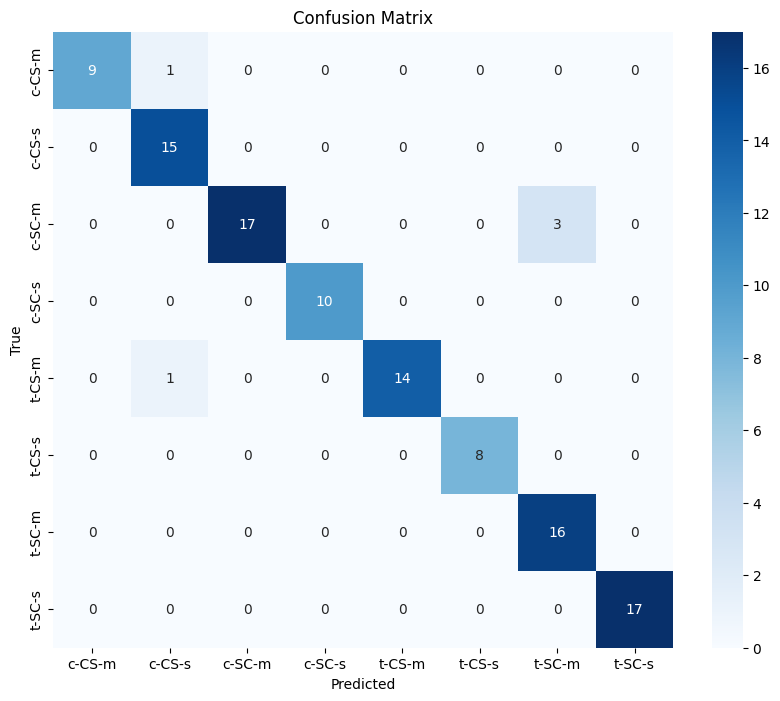

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('Data_Cortex_Nuclear.csv')

data = data.dropna()

numeric_columns = data.select_dtypes(include=[np.number]).columns
X = data[numeric_columns].values
y = data['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

precision_per_class = precision_score(y_test_classes, y_pred_classes, average=None)
recall_per_class = recall_score(y_test_classes, y_pred_classes, average=None)
f1_per_class = f1_score(y_test_classes, y_pred_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})
print("\nClass-wise Metrics:")
print(metrics_df.to_string(index=False))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()